In [1]:
import os
import hashlib
from PIL import Image
import numpy as np

def compute_md5(img_path):
    """Calcule un hash MD5 d'une image."""
    img = Image.open(img_path).convert("RGB")
    img_array = np.array(img)
    img_bytes = img_array.tobytes()
    return hashlib.md5(img_bytes).hexdigest()

def check_global_uniqueness(folder_list):
    print(f"🔎 Vérification globale unicité entre {len(folder_list)} dossiers...\n")
    hashes = {}
    duplicates = []

    for folder_path in folder_list:
        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.png')):
                img_path = os.path.join(folder_path, filename)
                img_hash = compute_md5(img_path)

                if img_hash in hashes:
                    duplicates.append((img_path, hashes[img_hash]))
                else:
                    hashes[img_hash] = img_path

    total_images = len(hashes) + len(duplicates)
    print(f"✅ Total images scannées : {total_images}")

    if len(duplicates) == 0:
        print("🎯 Aucune duplication détectée entre tous les dossiers.\n")
    else:
        print(f"⚠️ {len(duplicates)} duplicats détectés !\n")
        for dup1, dup2 in duplicates:
            print(f" - {dup1} est un duplicat de {dup2}")

folders = [
    'stegoimagesdataset/train/train/clean',
    'stegoimagesdataset/train/train/stego',
    'stegoimagesdataset/val/val/clean',
    'stegoimagesdataset/val/val/stego',
    'stegoimagesdataset/test/test/clean',
    'stegoimagesdataset/test/test/stego'
]

check_global_uniqueness(folders)


🔎 Vérification globale unicité entre 6 dossiers...

✅ Total images scannées : 32000
⚠️ 30 duplicats détectés !

 - stegoimagesdataset/train/train/clean\00309.png est un duplicat de stegoimagesdataset/train/train/clean\00308.png
 - stegoimagesdataset/train/train/clean\00320.png est un duplicat de stegoimagesdataset/train/train/clean\00198.png
 - stegoimagesdataset/train/train/clean\00375.png est un duplicat de stegoimagesdataset/train/train/clean\00351.png
 - stegoimagesdataset/train/train/clean\00434.png est un duplicat de stegoimagesdataset/train/train/clean\00093.png
 - stegoimagesdataset/train/train/clean\00436.png est un duplicat de stegoimagesdataset/train/train/clean\00291.png
 - stegoimagesdataset/train/train/clean\00448.png est un duplicat de stegoimagesdataset/train/train/clean\00087.png
 - stegoimagesdataset/train/train/clean\00466.png est un duplicat de stegoimagesdataset/train/train/clean\00441.png
 - stegoimagesdataset/train/train/clean\01092.png est un duplicat de stegoim

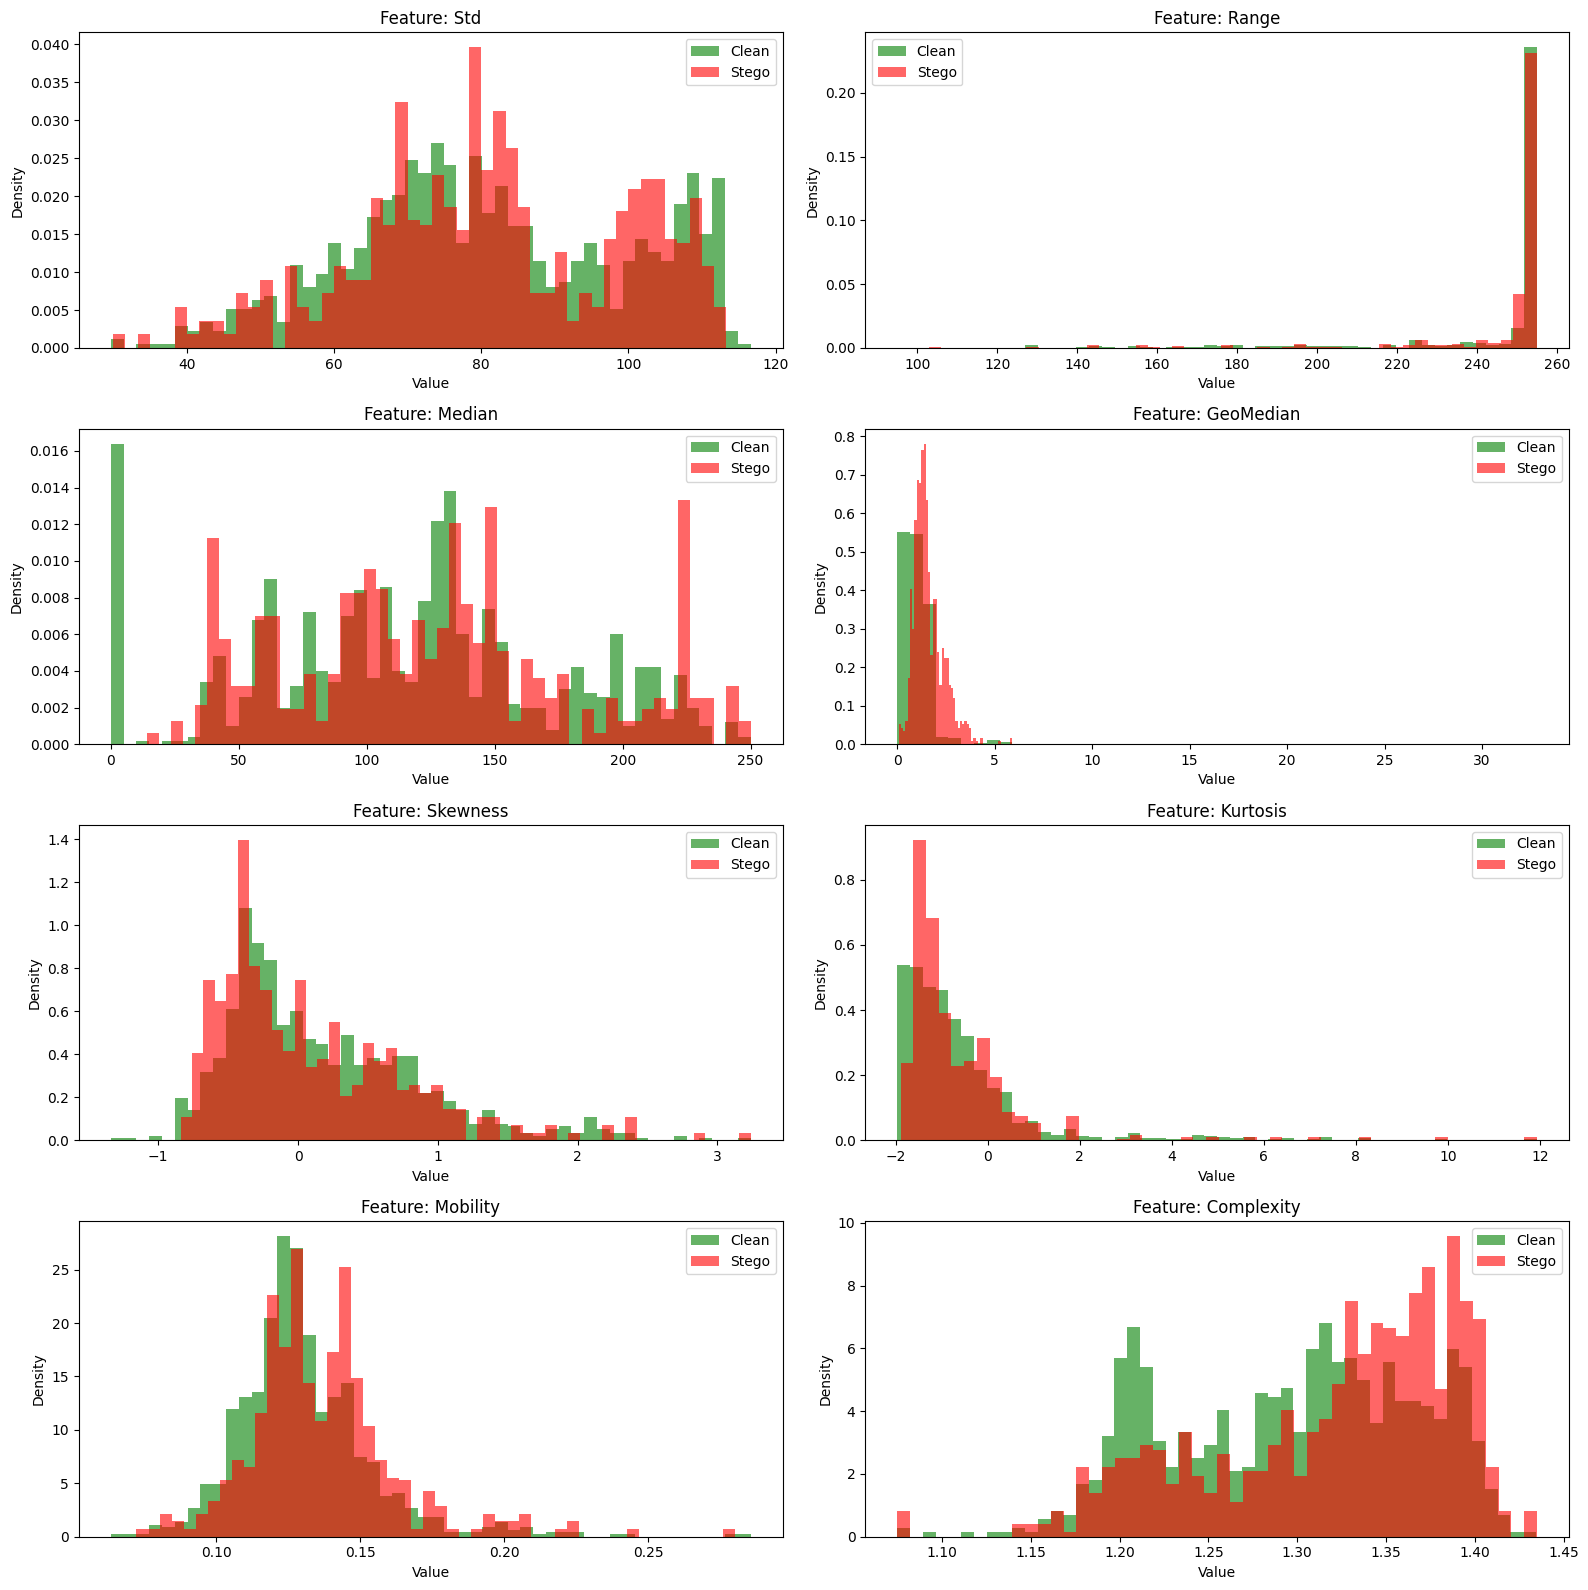

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.stats import kurtosis, skew
import warnings

clean_dir = 'stegoimagesdataset/test/test/clean'
stego_dir = 'stegoimagesdataset/test/test/stego'

def extract_stat_features(img):
    img_gray = img.convert('L')
    data = np.asarray(img_gray).astype(np.float32).flatten()
    data = np.clip(data, 1e-5, 255)
    eps = 1e-5

    try:
        std = np.std(data)
        range_val = np.max(data) - np.min(data)
        median = np.median(data)
        geo_median = np.exp(np.mean(np.log(data + eps)))
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            skewness = skew(data)
            kurt = kurtosis(data)

        d1 = np.diff(data)
        d2 = np.diff(d1)

        var0 = np.var(data) + eps
        var1 = np.var(d1) + eps
        var2 = np.var(d2) + eps

        mobility = np.sqrt(var1 / var0)
        raw_complexity = (var2 / var1) - (var1 / var0)
        raw_complexity = np.maximum(raw_complexity, 0)
        complexity = np.sqrt(raw_complexity)

        return [std, range_val, median, geo_median, skewness, kurt, mobility, complexity]

    except Exception as e:
        print("Erreur feature:", e)
        return [0] * 8

clean_feats = []
stego_feats = []

max_samples = 1000

for img_name in os.listdir(clean_dir)[:max_samples]:
    path = os.path.join(clean_dir, img_name)
    try:
        img = Image.open(path)
        feats = extract_stat_features(img)
        clean_feats.append(feats)
    except:
        continue

for img_name in os.listdir(stego_dir)[:max_samples]:
    path = os.path.join(stego_dir, img_name)
    try:
        img = Image.open(path)
        feats = extract_stat_features(img)
        stego_feats.append(feats)
    except:
        continue

clean_feats = np.array(clean_feats)
stego_feats = np.array(stego_feats)

feature_names = ['Std', 'Range', 'Median', 'GeoMedian', 'Skewness', 'Kurtosis', 'Mobility', 'Complexity']

plt.figure(figsize=(16, 16))
for i in range(8):
    plt.subplot(4, 2, i+1)
    plt.hist(clean_feats[:, i], bins=50, alpha=0.6, label='Clean', color='green', density=True)
    plt.hist(stego_feats[:, i], bins=50, alpha=0.6, label='Stego', color='red', density=True)
    plt.title(f'Feature: {feature_names[i]}')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.show()


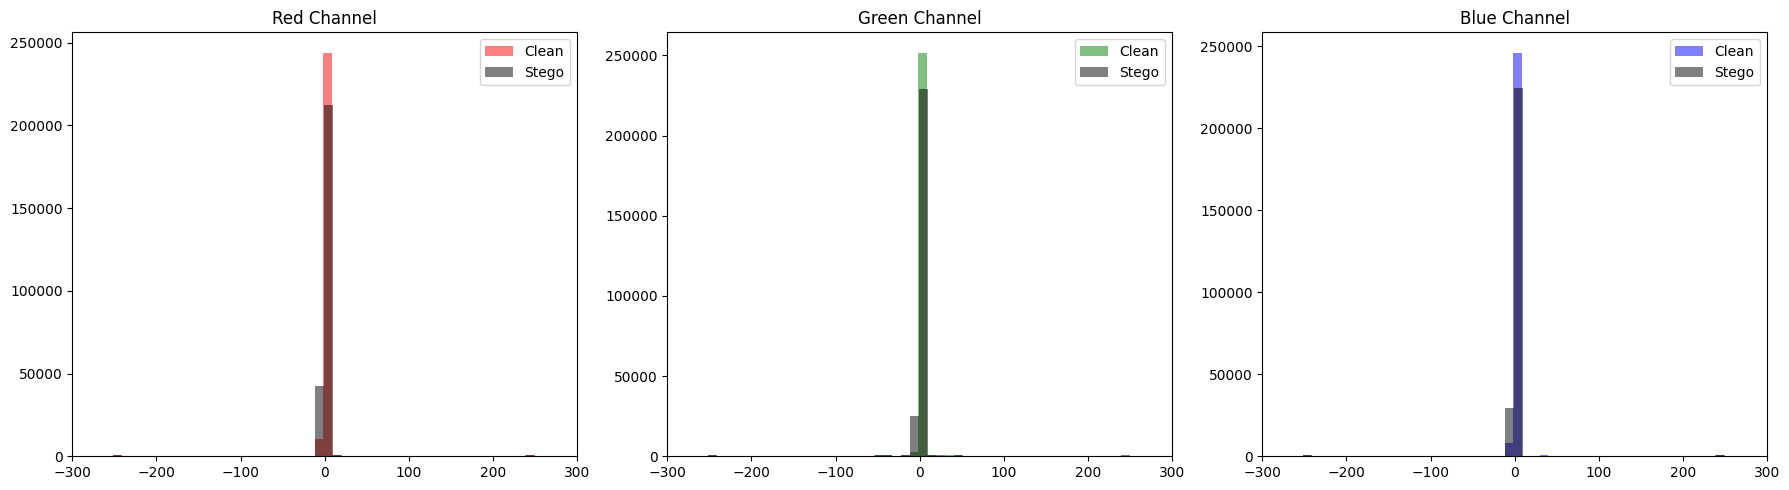

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

def plot_laplacian_superposed(clean_path, stego_path):
    img_clean = np.array(Image.open(clean_path).convert('RGB'))
    img_stego = np.array(Image.open(stego_path).convert('RGB'))

    colors = ['r', 'g', 'b']
    channel_names = ['Red', 'Green', 'Blue']

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for i in range(3):
        laplacian_clean = cv2.Laplacian(img_clean[:, :, i], cv2.CV_32F).flatten()
        laplacian_stego = cv2.Laplacian(img_stego[:, :, i], cv2.CV_32F).flatten()

        axes[i].hist(laplacian_clean, bins=100, color=colors[i], alpha=0.5, label='Clean')
        axes[i].hist(laplacian_stego, bins=100, color='black', alpha=0.5, label='Stego')

        axes[i].set_title(f'{channel_names[i]} Channel')
        axes[i].legend()
        axes[i].set_xlim(-300, 300)

    plt.tight_layout()
    plt.show()

plot_laplacian_superposed(
    'stegoimagesdataset/test/test/clean/04001.png',
    'stegoimagesdataset/test/test/stego/image_04001_html_0.png'
)


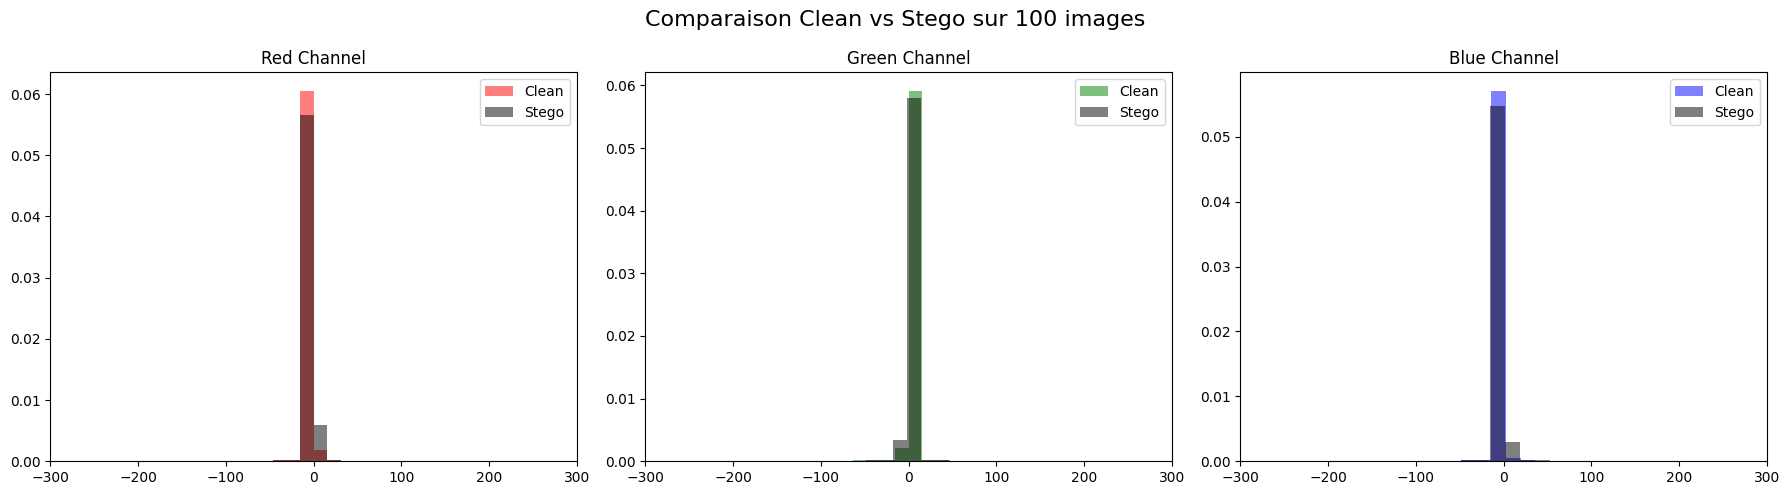

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
import random

def plot_laplacian_superposed_batch(clean_dir, stego_dir, n_images=10):
    clean_imgs = sorted([f for f in os.listdir(clean_dir) if f.endswith('.png')])
    selected_imgs = random.sample(clean_imgs, n_images)

    laplacians_clean = {0: [], 1: [], 2: []}
    laplacians_stego = {0: [], 1: [], 2: []}

    for img_name in selected_imgs:
        base_id = os.path.splitext(img_name)[0]
        clean_path = os.path.join(clean_dir, img_name)

        stego_candidates = [f for f in os.listdir(stego_dir) if base_id in f]
        if not stego_candidates:
            continue
        stego_name = random.choice(stego_candidates)
        stego_path = os.path.join(stego_dir, stego_name)

        img_clean = np.array(Image.open(clean_path).convert('RGB'))
        img_stego = np.array(Image.open(stego_path).convert('RGB'))

        for c in range(3):
            laplacians_clean[c].append(cv2.Laplacian(img_clean[:, :, c], cv2.CV_32F).flatten())
            laplacians_stego[c].append(cv2.Laplacian(img_stego[:, :, c], cv2.CV_32F).flatten())

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    colors = ['r', 'g', 'b']
    channel_names = ['Red', 'Green', 'Blue']

    for i in range(3):
        all_clean = np.concatenate(laplacians_clean[i])
        all_stego = np.concatenate(laplacians_stego[i])

        axes[i].hist(all_clean, bins=100, color=colors[i], alpha=0.5, label='Clean', density=True)
        axes[i].hist(all_stego, bins=100, color='black', alpha=0.5, label='Stego', density=True)

        axes[i].set_title(f'{channel_names[i]} Channel')
        axes[i].legend()
        axes[i].set_xlim(-300, 300)

    plt.suptitle(f'Comparaison Clean vs Stego sur {n_images} images', fontsize=16)
    plt.tight_layout()
    plt.show()

plot_laplacian_superposed_batch(
    clean_dir='stegoimagesdataset/test/test/clean',
    stego_dir='stegoimagesdataset/test/test/stego',
    n_images=100
)


In [89]:
import numpy as np
import os
import random
from PIL import Image
import cv2
from scipy.stats import ks_2samp

def laplacian_ks_test(clean_dir, stego_dir, n_images=50):
    clean_imgs = sorted([f for f in os.listdir(clean_dir) if f.endswith('.png')])
    selected_imgs = random.sample(clean_imgs, n_images)

    laplacians_clean = {0: [], 1: [], 2: []}
    laplacians_stego = {0: [], 1: [], 2: []}

    for img_name in selected_imgs:
        base_id = os.path.splitext(img_name)[0]
        clean_path = os.path.join(clean_dir, img_name)

        stego_candidates = [f for f in os.listdir(stego_dir) if base_id in f]
        if not stego_candidates:
            continue
        stego_name = random.choice(stego_candidates)
        stego_path = os.path.join(stego_dir, stego_name)

        img_clean = np.array(Image.open(clean_path).convert('RGB'))
        img_stego = np.array(Image.open(stego_path).convert('RGB'))

        for c in range(3):
            laplacians_clean[c].append(cv2.Laplacian(img_clean[:, :, c], cv2.CV_32F).flatten())
            laplacians_stego[c].append(cv2.Laplacian(img_stego[:, :, c], cv2.CV_32F).flatten())

    results = {}
    for c in range(3):
        data_clean = np.concatenate(laplacians_clean[c])
        data_stego = np.concatenate(laplacians_stego[c])

        # Kolmogorov-Smirnov Test
        stat, p_value = ks_2samp(data_clean, data_stego)

        results[c] = (stat, p_value)

    return results

results = laplacian_ks_test(
    clean_dir='stegoimagesdataset/test/test/clean',
    stego_dir='stegoimagesdataset/test/test/stego',
    n_images=100
)

channel_names = ['Red', 'Green', 'Blue']
for i in range(3):
    stat, p_value = results[i]
    print(f"Canal {channel_names[i]} ➔ KS-Statistic: {stat:.4f} | p-value: {p_value:.4e}")

    if p_value < 0.05:
        print("Différence significative détectée !")
    else:
        print("Pas de différence significative.")


Canal Red ➔ KS-Statistic: 0.0643 | p-value: 0.0000e+00
Différence significative détectée !
Canal Green ➔ KS-Statistic: 0.0636 | p-value: 0.0000e+00
Différence significative détectée !
Canal Blue ➔ KS-Statistic: 0.0641 | p-value: 0.0000e+00
Différence significative détectée !
